# **Object-Oriented Stencil Development** #

### **Introduction**
After establishing the basics of using GT4Py, we'll take a look at developing an object-oriented coding approach with GT4Py.  Much of the object-oriented work comes from the development of [Pace](https://github.com/NOAA-GFDL/pace), the implementation of the FV3GFS / SHiELD atmospheric model using GT4Py and [DaCe](https://github.com/spcl/dace).  The `StencilFactory` object will be introduced and demoed.

### **Creating the `StencilFactory` object**

The `StencilFactory` object enables the sharing of stencil properties across multiple stencils as well as "build and execute" the stencil.  To help ease the introduction, the [`boilerplate` module](./boilerplate.py) contains a function `get_one_tile_factory` that takes the domain size, halo size, and backend of interest and returns a `StencilFactory` object.  For more details about the objects needed to create the `StencilFactory`, the reader can view the [`get_one_tile_factory`](./boilerplate.py#get_one_tile_factory) function.

In [18]:
from boilerplate import get_one_tile_factory, plot_field_at_k0
from ndsl import StencilFactory

nx = 6
ny = 6
nz = 1
nhalo = 1
backend="numpy"

stencil_factory: StencilFactory = get_one_tile_factory(nx, ny, nz, nhalo, backend)

### **Creating the Copy stencil**

The `NDSL` and `gt4py` module contain key terms that will be used to create the stencil.  Many terms are covered in the [GT4Py basic tutorial](./01_basics.ipynb) notebook, but we'll briefly recap.

- `FloatField` : This type can generally can be thought of as a `gt4py` 3-dimensional `numpy` array of floating point values.

- `computation(PARALLEL)` : This keyword combination means that there is no assumed order to perform calcuations in the `k` (3rd) dimension of a `gt4py` storage.  `PARALLEL` can be replaced by `FORWARD` or `BACKWARD` for serialized calculations in the `k` dimension.

- `interval(...)` : This keyword specifies the range of computation in the `k` dimension.\

The code below contains the Copy stencil implementation.

In [19]:
from ndsl.dsl.typing import FloatField
from gt4py.cartesian.gtscript import PARALLEL, computation, interval

def copy_field_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in

Note that a decorator does not surround this stencil as shown before in the [basic tutorial](./01_basics.ipynb).  Instead, we'll use the `StencilFactory` to "initiate" the stencil.

### **Creating a class that performs a stencil computation**

Using the `StencilFactory` object created earlier, the code will now create a class `CopyField` that takes `copy_field_stencil` and defines the computation domain from the parameters `origin` and `domain` within `__init__`. `origin` indicates the "starting" point of the stencil calculation, and `domain` indicates the extent of the stencil calculation in the 3 dimensions.  Note that when creating `stencil_factory`, a 6 by 6 by 1 sized domain surrounded with a halo layer of size 1 was defined (see the initialization of `grid_indexing` at [boilerplate.py](./boilerplate.py#get_one_tile_factory)).  Thus, whenever a `CopyField` object is created, it will perform calcuations within the 6 by 6 by 1 domain (specified by `domain=grid_indexing.domain_compute()`), and the 'origin' will start at the [0,0,0] location of the 6 by 6 by 1 grid (specified by `origin=grid_indexing.origin_compute()`).

In [20]:
class CopyField:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field = stencil_factory.from_origin_domain(
            copy_field_stencil, # <-- gt4py stencil function wrapped into NDSL
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__( # <-- Runtime path
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field(field_in, field_out)
        
        
copy_field = CopyField(stencil_factory)

### **Allocating arrays in `gt4py`**

The next code section will create arrays using `gt_storage`.  For more information about `gt_storage`, see the [GT4Py Basic tutorial](./01_basics.ipynb#Copy_Stencil_example).

Min and max values: 1.0 0.0


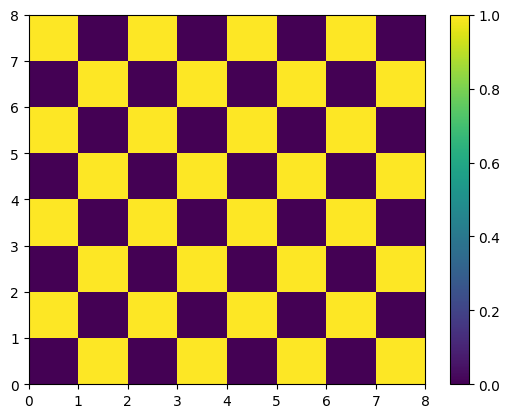

Min and max values: 0.0 0.0


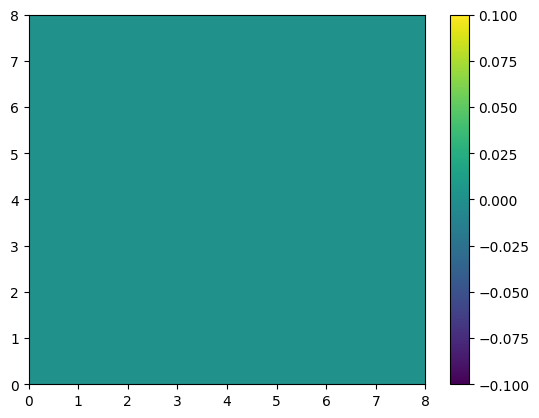

In [21]:
## Change this to Quantity

import gt4py.storage as gt_storage
import numpy as np

size = (nx + 2 * nhalo) * (ny + 2 * nhalo) * nz
shape = (nx + 2 * nhalo, ny + 2 * nhalo, nz)


qty_zero = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=shape,
)

qty_out = gt_storage.zeros(
    backend=backend,
    dtype=float,
    shape=shape,
)

arr = np.zeros(shape)
qty_in = gt_storage.from_array(
    data=np.indices(shape).sum(axis=0) % 2,
    backend=backend,
    dtype=float,
)

plot_field_at_k0(qty_in)
plot_field_at_k0(qty_out)


### **Calling `copy_field` stencil**

The code will call `copy_field` to execute `copy_field_stencil` using the previously defined `gt_storage` arrays and plot the result at `k = 0`.

Min and max values: 1.0 0.0


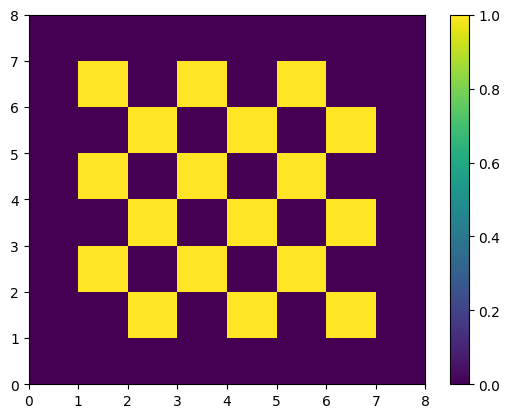

In [22]:
copy_field(qty_in, qty_out)
plot_field_at_k0(qty_out)

From the plot, we see that the copy is only applied to the inner 6 by 6 area and not the entire domain.  The stencil in this case only applies in this "domain" and not the "halo" region surrounding the domain.

### **Applying a J offset**

The next example will create a stencil that takes a `gt_storage` as an input, shift the input by 1 in the `-j` direction, and write it to an output `gt_storage`.  This stencil is defined in `copy_field_offset_stencil`.

Note that in `copy_field_offset_stencil`, the shift in the J dimension is performed by referencing the `J` object from `gt4py.cartesian.gtscript` for simplicity.  This reference will apply the shift in J to the entire input domain.  Another potential way to perform the shift without referencing the `J` object is to write `[0,-1,0]` (assuming that the variable being modified is 3-dimensional) instead of `[J-1]`.

With the stencil in place, a class `CopyFieldOffset` is defined using the `StencilFactory` object and `copy_field_offset_stencil`.  The class is instantiated and demonstrated to shift `qty_in` by 1 in the J-dimension and write to `qty_out`.

Min and max values: 0.0 0.0


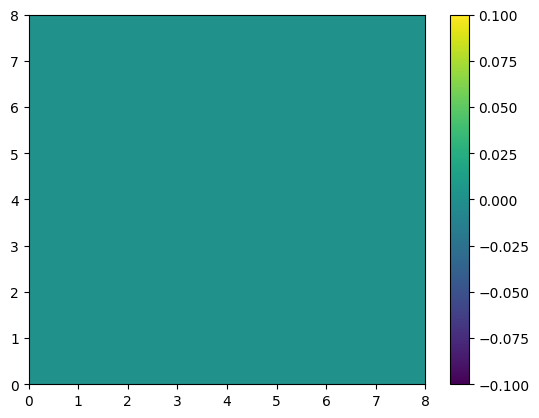

In [23]:
from gt4py.cartesian.gtscript import J

def copy_field_offset_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in[J-1]
        
class CopyFieldOffset:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field_offset = stencil_factory.from_origin_domain(
            copy_field_offset_stencil,
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__(
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field_offset(field_in, field_out)
        
copy_field_offset = CopyFieldOffset(stencil_factory)
        
copy_field(qty_zero, qty_out)
plot_field_at_k0(qty_out)

Min and max values: 1.0 0.0


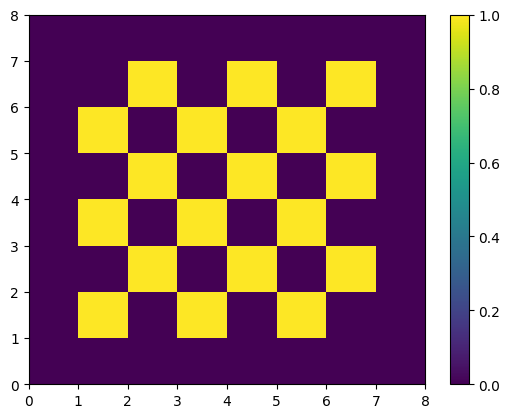

In [24]:
copy_field_offset(qty_in, qty_out)
plot_field_at_k0(qty_out)

### **Limits to offset : Cannot set offset outside of usable domain**

In [35]:
def copy_field_offset_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out = field_in[J-2]
        
class CopyFieldOffset:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field_offset = stencil_factory.from_origin_domain(
            copy_field_offset_stencil,
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__(
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field_offset(field_in, field_out)
        
copy_field_offset = CopyFieldOffset(stencil_factory)

copy_field_offset(qty_in, qty_out)


(1, 1, 0)

### **Example demonstrating error when writing to offset outputs**

While offsets can be applied to all input `gt_storage` variables in `gt4py`, output `gt_storage` varaibles cannot have such offsets.  When an offset is applied to an output stencil calcuation, the error `GTScriptSyntaxError: Assignment to non-zero offsets is not supported.` will be displayed.

In [25]:
from gt4py.cartesian.gtscript import J

def copy_field_offset_output_stencil(field_in: FloatField, field_out: FloatField):
    with computation(PARALLEL), interval(...):
        field_out[0,1,0] = field_in
        
class CopyFieldOffsetOutput:
    def __init__(self, stencil_factory: StencilFactory):
        grid_indexing = stencil_factory.grid_indexing
        self._copy_field_offset_output = stencil_factory.from_origin_domain(
            copy_field_offset_output_stencil,
            origin=grid_indexing.origin_compute(),
            domain=grid_indexing.domain_compute(),
        )

    def __call__(
        self,
        field_in: FloatField,
        field_out: FloatField,
    ):
        self._copy_field_offset_output(field_in, field_out)
        
copy_field_offset_output = CopyFieldOffsetOutput(stencil_factory)
        

GTScriptSyntaxError: Assignment to non-zero offsets is not supported.